<a href="https://colab.research.google.com/github/myarist/Dicoding/blob/main/Project/Animals%20Classification%20-%20Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
from io import BytesIO
from IPython.display import Image as IMG
from google.colab import files
from keras.preprocessing import image
from shutil import copyfile
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from urllib.request import urlopen
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import zipfile, os
import warnings
warnings.filterwarnings("ignore")

## Install Kaggle

In [ ]:
!pip install -q kaggle

## Upload kaggle.json API

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"myarist","key":"f6dfa32267e9bbe61f8ef59a64465be3"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


# Data

## Download

Download data from [this link](https://www.kaggle.com/madisona/translated-animals10/version/1)

In [ ]:
!kaggle datasets download -d madisona/translated-animals10

 96% 565M/586M [00:02<00:00, 226MB/s]
100% 586M/586M [00:02<00:00, 215MB/s]


## Extract

In [ ]:
!mkdir animals
!unzip -qq translated-animals10.zip -d animals
!ls animals

animals10


## Inspect

In [ ]:
animals = ['chicken', 'spider', 'sheep', 'butterfly', 'elephant', 'cat']

for animal in animals:
    print(f'{animal} images: ', len(os.listdir(f'/content/animals/animals10/raw-img/{animal}')))

chicken images:  3098
spider images:  4821
sheep images:  1820
butterfly images:  2112
elephant images:  1446
cat images:  1668


## Folder

In [ ]:
try:
  os.mkdir('/content/animals/animals10/training')
  os.mkdir('/content/animals/animals10/testing')
  for animal in animals:
    os.mkdir(f'/content/animals/animals10/training/{animal}')
    os.mkdir(f'/content/animals/animals10/testing/{animal}')
except OSError:
  pass

## Split

In [ ]:
def split_data(images_path, training_path, testing_path, split_size):
    files = []
    for filename in os.listdir(images_path):
        file = images_path + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " others")

    training_length = int(len(files) * split_size)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[training_length:]

    for filename in training_set:
        this_file = images_path + filename
        destination = training_path + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = images_path + filename
        destination = testing_path + filename
        copyfile(this_file, destination)

split_size = 0.8 # 80% Data Training and 20% Data Validation

chicken_images_path = "/content/animals/animals10/raw-img/chicken/"
chicken_train_path = "/content/animals/animals10/training/chicken/"
chicken_test_path = "/content/animals/animals10/testing/chicken/"
split_data(chicken_images_path, chicken_train_path, chicken_test_path, split_size)

spider_images_path = "/content/animals/animals10/raw-img/spider/"
spider_train_path = "/content/animals/animals10/training/spider/"
spider_test_path = "/content/animals/animals10/testing/spider/"
split_data(spider_images_path, spider_train_path, spider_test_path, split_size)

sheep_images_path = "/content/animals/animals10/raw-img/sheep/"
sheep_train_path = "/content/animals/animals10/training/sheep/"
sheep_test_path = "/content/animals/animals10/testing/sheep/"
split_data(sheep_images_path, sheep_train_path, sheep_test_path, split_size)

butterfly_images_path = "/content/animals/animals10/raw-img/butterfly/"
butterfly_train_path = "/content/animals/animals10/training/butterfly/"
butterfly_test_path = "/content/animals/animals10/testing/butterfly/"
split_data(butterfly_images_path, butterfly_train_path, butterfly_test_path, split_size)

elephant_images_path = "/content/animals/animals10/raw-img/elephant/"
elephant_train_path = "/content/animals/animals10/training/elephant/"
elephant_test_path = "/content/animals/animals10/testing/elephant/"
split_data(elephant_images_path, elephant_train_path, elephant_test_path, split_size)

cat_images_path = "/content/animals/animals10/raw-img/cat/"
cat_train_path = "/content/animals/animals10/training/cat/"
cat_test_path = "/content/animals/animals10/testing/cat/"
split_data(cat_images_path, cat_train_path, cat_test_path, split_size)

## Size

In [ ]:
total_train = len(os.listdir(chicken_train_path)) + len(os.listdir(spider_train_path)) + \
              len(os.listdir(sheep_train_path)) + len(os.listdir(butterfly_train_path)) + \
              len(os.listdir(elephant_train_path)) + len(os.listdir(cat_train_path))
total_test  = len(os.listdir(chicken_test_path)) + len(os.listdir(spider_test_path)) + \
              len(os.listdir(sheep_test_path)) + len(os.listdir(butterfly_test_path)) + \
              len(os.listdir(elephant_test_path)) + len(os.listdir(cat_test_path))

print("We have a total training data of " + str(total_train) + " rows and validation data of " + str(total_test))

We have a total training data of 11969 rows and validation data of 2996


# Modelling

## Image Augmentation

In [ ]:
TRAINING_DIR = '/content/animals/animals10/training'
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    width_shift_range = 0.1,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
) 

train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR, 
    batch_size = 64,
    class_mode = 'categorical',
    target_size = (150,150)
)

VALIDATION_DIR = "/content/animals/animals10/testing"
validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size = 64,
    class_mode = 'categorical',
    target_size = (150, 150)
)

Found 11969 images belonging to 6 classes.
Found 2996 images belonging to 6 classes.


## Callbacks

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=5, 
    min_lr=1.5e-5
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=12,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True
)

## Plot Function

In [ ]:
plt.style.use('seaborn-whitegrid')

def plot_acc(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epochs = range(len(acc))
  plt.subplot(1, 2, 1)
  acc_plot, = plt.plot(epochs, acc, 'r')
  val_acc_plot, = plt.plot(epochs, val_acc, 'b')
  plt.title('Training and Validation Accuracy')
  plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])


def plot_loss(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  plt.subplot(1, 2, 2)
  loss_plot, = plt.plot(epochs, loss, 'r')
  val_loss_plot, = plt.plot(epochs, val_loss, 'b')
  plt.title('Training and Validation Loss')
  plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])

def plot_history(history):
  plt.figure(figsize=(15,5))
  plot_acc(history)
  plot_loss(history)

## CNN Model

In [ ]:
tf.keras.backend.clear_session()

model_simple = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

model_simple.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

### Running

In [ ]:
model_simple.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

history_simple = model_simple.fit(
    train_generator,
    epochs=100,
    callbacks = [reduce_lr, early_stop],
    verbose=1,
    validation_data=validation_generator
)

Epoch 1/100
188/188 [==============================] - 99s 515ms/step - loss: 1.6046 - accuracy: 0.3572 - val_loss: 1.5737 - val_accuracy: 0.3428
Epoch 2/100
188/188 [==============================] - 94s 500ms/step - loss: 1.3466 - accuracy: 0.4841 - val_loss: 1.3496 - val_accuracy: 0.4873
Epoch 3/100
188/188 [==============================] - 96s 510ms/step - loss: 1.1573 - accuracy: 0.5727 - val_loss: 1.1472 - val_accuracy: 0.5728
Epoch 4/100
188/188 [==============================] - 95s 506ms/step - loss: 1.1117 - accuracy: 0.5903 - val_loss: 1.2286 - val_accuracy: 0.5514
Epoch 5/100
188/188 [==============================] - 93s 495ms/step - loss: 1.0545 - accuracy: 0.6190 - val_loss: 0.9016 - val_accuracy: 0.6776
Epoch 6/100
188/188 [==============================] - 95s 503ms/step - loss: 0.9639 - accuracy: 0.6549 - val_loss: 1.2379 - val_accuracy: 0.5381
Epoch 7/100
188/188 [==============================] - 95s 503ms/step - loss: 0.9817 - accuracy: 0.6530 - val_loss: 0.8552 -

### Visualize

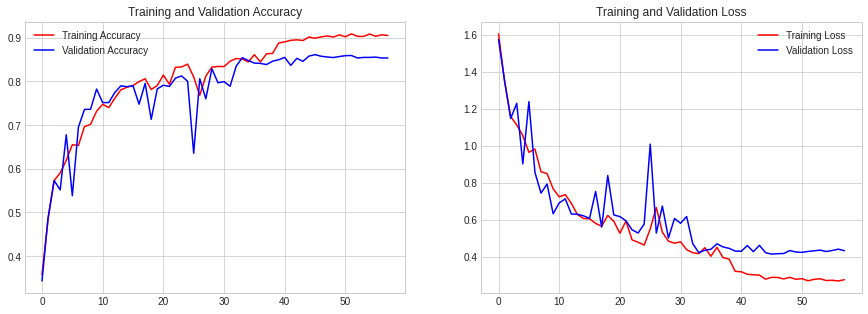

In [ ]:
plot_history(history_simple)

### Evaluate

In [ ]:
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size=159,
    class_mode='categorical',
    target_size=(150, 150),
    shuffle = False
)

filenames = validation_generator.filenames
nb_samples = len(filenames)

Y_pred = model_simple.predict_generator(validation_generator, steps = nb_samples)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

print('Classification Report')
target_names = ['chicken',
                'spider',
                'sheep',
                'butterfly',
                'elephant',
                'cat']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Found 2996 images belonging to 6 classes.
Confusion Matrix
[[388   2  13   4   4  12]
 [ 16 235  25  22  23  13]
 [ 12   7 567  16  12   6]
 [  4   1   3 267  13   2]
 [  4   4  15  36 303   2]
 [ 80   3  29  21  12 820]]
Classification Report
              precision    recall  f1-score   support

     chicken       0.77      0.92      0.84       423
      spider       0.93      0.70      0.80       334
       sheep       0.87      0.91      0.89       620
   butterfly       0.73      0.92      0.81       290
    elephant       0.83      0.83      0.83       364
         cat       0.96      0.85      0.90       965

    accuracy                           0.86      2996
   macro avg       0.85      0.86      0.85      2996
weighted avg       0.87      0.86      0.86      2996



### Save

In [ ]:
model_simple.save_weights('model_simple_weights.h5')
model_simple.save('model_simple.h5')

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_simple)
tflite_model_simple = converter.convert()

with tf.io.gfile.GFile('model_simple.tflite', 'wb') as f:
  f.write(tflite_model_simple)

INFO:tensorflow:Assets written to: /tmp/tmpiv8h7ttx/assets


## Transfer Learning (InceptionV3)

In [ ]:
tf.keras.backend.clear_session()

model_inception = tf.keras.models.Sequential([
    InceptionV3(weights = "imagenet", include_top = False, input_shape = (150, 150, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

model_inception.layers[0].trainable = False

model_inception.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dropout (Dropout)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               9437696   
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 3078      
Total params: 31,243,558
Trainable params: 9,440,774
Non-trainable params: 21,802,784
_________________________________________________________________


### Running

In [ ]:
model_inception.compile(
    optimizer = 'adam', 
    loss = 'categorical_crossentropy', 
    metrics = ['accuracy']
)

history_inception = model_inception.fit(
    train_generator,
    epochs=100,
    callbacks = [reduce_lr, early_stop],
    verbose=1,
    validation_data=validation_generator
)

Epoch 1/100
188/188 [==============================] - 105s 537ms/step - loss: 2.0608 - accuracy: 0.8604 - val_loss: 0.1644 - val_accuracy: 0.9503
Epoch 2/100
188/188 [==============================] - 99s 526ms/step - loss: 0.2648 - accuracy: 0.9119 - val_loss: 0.1399 - val_accuracy: 0.9559
Epoch 3/100
188/188 [==============================] - 99s 527ms/step - loss: 0.2282 - accuracy: 0.9253 - val_loss: 0.1452 - val_accuracy: 0.9513
Epoch 4/100
188/188 [==============================] - 99s 527ms/step - loss: 0.2091 - accuracy: 0.9286 - val_loss: 0.1393 - val_accuracy: 0.9549
Epoch 5/100
188/188 [==============================] - 98s 521ms/step - loss: 0.2067 - accuracy: 0.9292 - val_loss: 0.1335 - val_accuracy: 0.9526
Epoch 6/100
188/188 [==============================] - 99s 527ms/step - loss: 0.1957 - accuracy: 0.9330 - val_loss: 0.1334 - val_accuracy: 0.9546
Epoch 7/100
188/188 [==============================] - 100s 531ms/step - loss: 0.1866 - accuracy: 0.9351 - val_loss: 0.1196

### Visualize

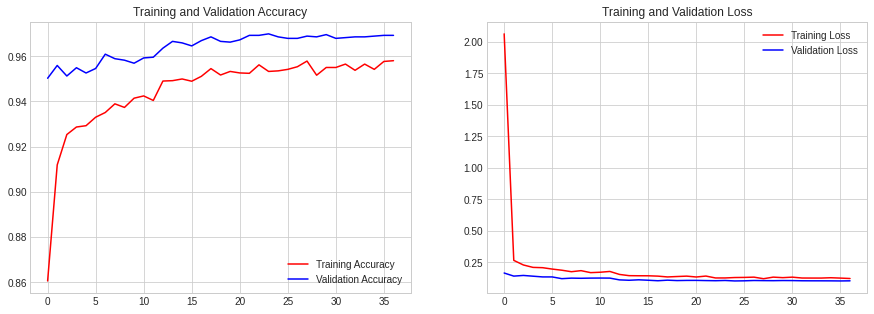

In [ ]:
plot_history(history_inception)

### Evaluate

In [ ]:
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size=159,
    class_mode='categorical',
    target_size=(150, 150),
    shuffle = False
)

filenames = validation_generator.filenames
nb_samples = len(filenames)

Y_pred = model_inception.predict_generator(validation_generator, steps = nb_samples)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

print('Classification Report')
target_names = ['chicken',
                'spider',
                'sheep',
                'butterfly',
                'elephant',
                'cat']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Found 2996 images belonging to 6 classes.
Confusion Matrix
[[405   1   2   2   1  12]
 [  0 323   5   0   5   1]
 [  3   2 604   0   6   5]
 [  0   0   2 282   5   1]
 [  0   1   4   9 349   1]
 [ 19   3   1   1   2 939]]
Classification Report
              precision    recall  f1-score   support

     chicken       0.95      0.96      0.95       423
      spider       0.98      0.97      0.97       334
       sheep       0.98      0.97      0.98       620
   butterfly       0.96      0.97      0.97       290
    elephant       0.95      0.96      0.95       364
         cat       0.98      0.97      0.98       965

    accuracy                           0.97      2996
   macro avg       0.97      0.97      0.97      2996
weighted avg       0.97      0.97      0.97      2996



### Save

In [ ]:
model_inception.save_weights('model_inception_weights.h5')
model_inception.save('model_inception.h5')

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_inception)
tflite_model_inception = converter.convert()

with tf.io.gfile.GFile('model_inception.tflite', 'wb') as f:
  f.write(tflite_model_inception)

INFO:tensorflow:Assets written to: /tmp/tmpcmxp3u5c/assets


# Predict

## Function

In [ ]:
def predict_image(image_upload, model = model_inception):
  im = image_upload
  im_array = np.asarray(im)
  im_array = im_array*(1/225)
  im_input = tf.reshape(im_array, shape = [1, 150, 150, 3])

  predict_array = model.predict(im_input)[0]

  import pandas as pd
  df = pd.DataFrame(predict_array)
  df = df.rename({0:'Probability'}, axis = 'columns')
  prod = ['butterfly',
          'cat',
          'chicken',
          'elephant',
          'sheep',
          'spider']
  df['Product'] = prod
  df = df[['Product', 'Probability']]

  predict_label = np.argmax(model.predict(im_input))

  if predict_label == 0:
      predict_product = 'Butterfly'
  elif predict_label == 1:
      predict_product = 'Cat'
  elif predict_label == 2:
      predict_product = 'Chicken'
  elif predict_label == 3:
      predict_product = 'Elephant'
  elif predict_label == 4:
      predict_product = 'Sheep'
  else:
      predict_product = 'Spider'

  return predict_product, df

## Predict Image

In [ ]:
def predict():
  uploaded = files.upload()

  for fn in uploaded.keys():
    path = fn
    img = image.load_img(path, target_size=(150,150))
    imgplot = plt.imshow(img)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    img = np.vstack([x])

  label, df = predict_image(img)

  print('\n')
  plt.show()
  print("\nThe image is detected as " + label)
  print('\n')
  print(df)
  print('\n')

Saving cute cat.jpg to cute cat.jpg




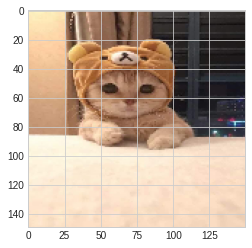


The image is detected as Cat


     Product  Probability
0  butterfly     0.012450
1        cat     0.923141
2    chicken     0.035219
3   elephant     0.003815
4      sheep     0.025192
5     spider     0.000183




In [ ]:
predict()